In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [61]:
data_folder = '/mnt/d/books/iitm/agentBased/data/fb/Mobility_Tamil_Nadu_Coronavirus_Disease_Prevention_Map_Apr_07_2020_Id/2618166339883143_2020-09-01_2020-10-01_csv/'
files = sorted([join(data_folder, f) for f in listdir(data_folder) if isfile(join(data_folder, f))])

In [2]:
quadkey_file = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/tn_quadkey.csv'
tn_quadkey = []
with open(quadkey_file, 'r') as fp:
    for line in fp:
        line = line.strip()
        if line:
            tn_quadkey.append(line)

In [3]:
def binary_search(arr, key, to):
    key = key[:to]
    l, r = 0, len(arr)
    while (l < r):
        mid = l + (r-l)//2
        if (arr[mid] > key):
            r = mid
        else:
            l = mid+1
    idx = l-1
    if (idx < 0 or arr[idx] != key):
        return -1
    return idx

In [53]:
def get_mobility(files, tn_quadkeys, to):
    n_tiles = len(tn_quadkeys)
    fb_mobility = None
    date = None;
    mobility_dir = '/mnt/d/books/iitm/agentBased/data/fb/mobility/'
    for f in files:
        df = pd.read_csv(f)
        new_date = datetime.strptime(df.date_time[0], '%Y-%m-%d %H:%M').date()
        if new_date != date:
            if fb_mobility is not None:
                mobility_file = join(mobility_dir, f'{str(date)}.csv')
                np.savetxt(mobility_file, mobility, delimiter=",")
                print(f'mobility data created for {date}')
            date = new_date
            fb_mobility = np.zeros((n_tiles, n_tiles))
        df = df[df.country == 'IN']
        base = df.n_baseline.to_numpy()
        winsorized_mean = winsorize(base[~np.isnan(base)], [0.1, 0.2]).mean()
        for idx, row in df.iterrows():
            start, end = str(row['start_quadkey']), str(row['end_quadkey'])
            i, j = binary_search(tn_quadkeys, start, to), binary_search(tn_quadkeys, end, to)
            if (i != -1 and j != -1):
                crisis = row['n_crisis']
                if math.isnan(crisis):
                    crisis = winsorized_mean * (1 + float(row['percent_change'])/100)
                fb_mobility[i, j] += float(crisis)
    if fb_mobility is not None:
        mobility_file = join(mobility_dir, f'{str(date)}.csv')
        np.savetxt(mobility_file, mobility, delimiter=",")
        print(f'mobility data created for {date}')
    return mobility_map

In [62]:
mobility_map = get_mobility(files, tn_quadkey, 9)

mobility data created for 2020-09-01
mobility data created for 2020-09-02
mobility data created for 2020-09-03
mobility data created for 2020-09-04
mobility data created for 2020-09-05
mobility data created for 2020-09-06
mobility data created for 2020-09-07
mobility data created for 2020-09-08
mobility data created for 2020-09-09
mobility data created for 2020-09-10
mobility data created for 2020-09-11
mobility data created for 2020-09-12
mobility data created for 2020-09-13
mobility data created for 2020-09-14
mobility data created for 2020-09-15
mobility data created for 2020-09-16
mobility data created for 2020-09-17
mobility data created for 2020-09-18
mobility data created for 2020-09-19
mobility data created for 2020-09-20
mobility data created for 2020-09-21
mobility data created for 2020-09-22
mobility data created for 2020-09-23
mobility data created for 2020-09-24
mobility data created for 2020-09-25
mobility data created for 2020-09-26
mobility data created for 2020-09-27
m

In [14]:
# convert mobility to distribution
mobility_dir = '/mnt/d/books/iitm/agentBased/data/fb/mobility'
mobility_save = '/mnt/d/books/iitm/agentBased/data/fb/mobility_final/'
mobility_files = sorted([f for f in listdir(mobility_dir) if isfile(join(mobility_dir, f))])

for f in mobility_files:
    mobility = np.genfromtxt(join(mobility_dir, f), delimiter=',')
    m, n = mobility.shape
    for i in range(m):
        for j in range(n):
            if mobility[i, j] == 0:
                mobility[i, j] = 1
    mobility /= mobility.sum(axis=1, keepdims=True)
    np.savetxt(join(mobility_save, f), mobility, delimiter=",")

In [ ]:
# For testing purposes

In [35]:
mobility = mobility_map['2020-05-01']
m, n = mobility.shape
for i in range(m):
    for j in range(n):
        if mobility[i, j] == 0:
            mobility[i, j] = 1
mobility /= mobility.sum(axis=1, keepdims=True)

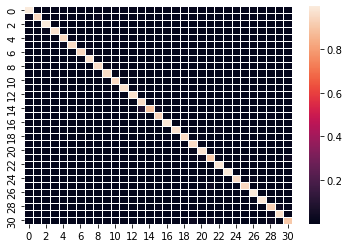

In [40]:
ax = sns.heatmap(mobility, linewidth=0.5)

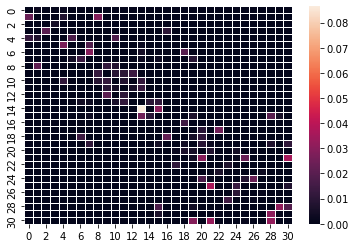

In [41]:
diag = np.diag(np.diag(mobility))
without_diag = mobility - diag
ax = sns.heatmap(without_diag, linewidth=0.5)